Goal: DEvelop an image classification model

Workflow:

0.libraries & device-agnostic

1.data acqusition

2.data preparation

3. transforming data

4. loading data with ImageFolder

5. loading image data with a custom Dataset

6.data augmentation

7. Model 0: TinyVGG without data augmmentation

8. explore loss curves

9.Model 1 TinyVGG with data augmentation

10. model results comparison

11. prediction on a custom image



In [125]:
import torch
from torch import nn

1. Data acqusition

In [126]:
import requests
import zipfile
from pathlib import Path
#setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
#check image folder existence, if not create one&download&prepare it
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    #download pizza, steak,sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak & sushi data...")
        f.write(request.content)
    #unzip data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...<<don't start feeling hungry though:)")
        zip_ref.extractall(image_path)


data\pizza_steak_sushi directory exists.


2. Data Preparation

In [127]:
#inspect contents of the data dir
import os 
def walk_through_dir(dir_path):
    for dirpath,dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)}images in '{dirpath}.")
        #print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [128]:
walk_through_dir(image_path)

There are 2 directories and 0images in 'data\pizza_steak_sushi.
There are 3 directories and 0images in 'data\pizza_steak_sushi\test.
There are 0 directories and 25images in 'data\pizza_steak_sushi\test\pizza.
There are 0 directories and 19images in 'data\pizza_steak_sushi\test\steak.
There are 0 directories and 31images in 'data\pizza_steak_sushi\test\sushi.
There are 3 directories and 0images in 'data\pizza_steak_sushi\train.
There are 0 directories and 78images in 'data\pizza_steak_sushi\train\pizza.
There are 0 directories and 75images in 'data\pizza_steak_sushi\train\steak.
There are 0 directories and 72images in 'data\pizza_steak_sushi\train\sushi.


In [129]:
#setting up train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


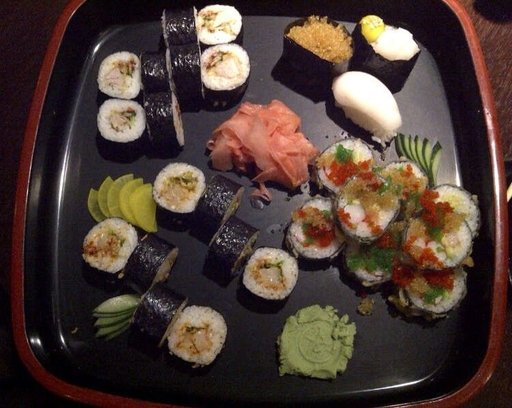

In [130]:
#2.1 Visualize an image
import random
from PIL import Image
random.seed(42)
#1.getting all image paths (all .jpg format files within the directory hierarchy)
image_path_list = list(image_path.glob("*/*/*.jpg")) #* means "any combination"
#2. get randomimage path
random_image_path = random.choice(image_path_list)
#3.get the name of the dir where image is stored
image_class = random_image_path.parent.stem
#4. Open image
img = Image.open(random_image_path)
#5. metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

3. Transforming data


goal = transform images to tensors and 
manipulate sizes and orientation
image[256,256,3] -->> image[64,64,3] #16x lesser pixels

In [131]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [132]:
#Image transform
data_transform = transforms.Compose([
    #resizing the images to 64 x 64
    transforms.Resize(size=(64, 64)),
    #randomly flip images horizontally
    transforms.RandomHorizontalFlip(p=0.5), #flip probability
    #turning image into a torch.Tensor
    transforms.ToTensor() #also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    
])

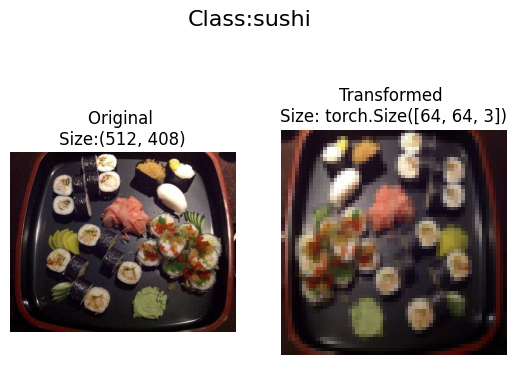

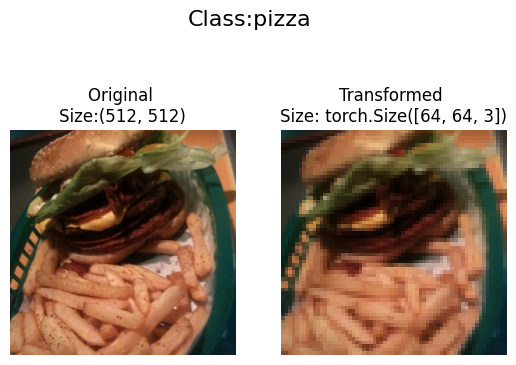

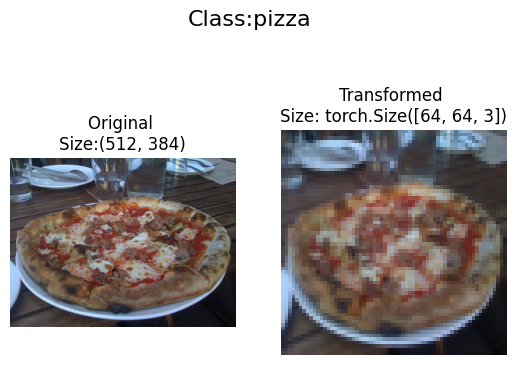

In [133]:
#create a function to plot transformed images from randomly chosen image paths 
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize:{f.size}")
            ax[0].axis("off")
            #transform and plot image
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class:{image_path.parent.stem}", fontsize=16)
plot_transformed_images(image_path_list,transform=data_transform, n=3)



4. Option 1:loading Image Data using ImageFolder


turn image data into a dataset that PyTorch can use

In [134]:
#using ImageFolder to create dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform= None)
test_data = datasets.ImageFolder(root=test_dir, transform = data_transform)
print(f"Train data:\n{train_data}\n Test data:\n {test_data}")


Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
 Test data:
 Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [138]:
#check class names as a list
class_names = train_data.classes
class_names


['pizza', 'steak', 'sushi']

In [137]:
#check clas names as a dictionary
class_dict = train_data.class_to_idx
class_dict


{'pizza': 0, 'steak': 1, 'sushi': 2}

In [139]:
#checking lengths of train and test data
len(train_data), len(test_data)

(225, 75)

In [140]:
#view images and labels (indexed)
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape:{img.shape}")
print(f"Image datatype:{img.dtype}")
print(f"Image label:{label}")
print(f"label datatype:{type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) ->[color_channels,height,width]
Image permute shape: torch.Size([64, 64, 3]) -> [height,width,color_channel]


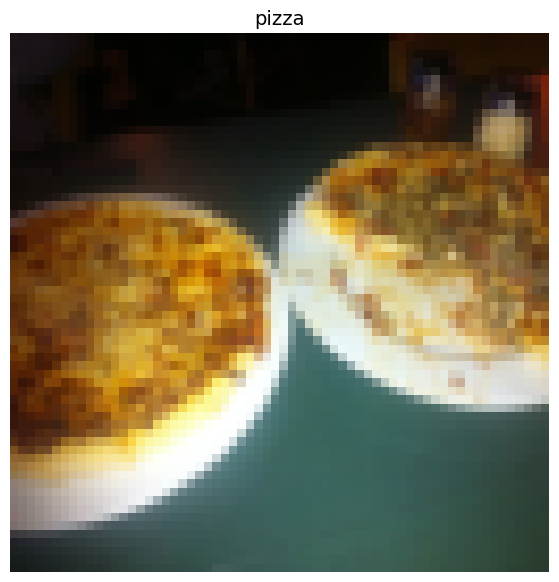

In [141]:
#rearranging  the order of dimensions
img_permute = img.permute(1,2,0)
#print out diff shapes
print(f"Original shape: {img.shape} ->[color_channels,height,width]")
print(f"Image permute shape: {img_permute.shape} -> [height,width,color_channel]")

#plot the image
plt.figure(figsize=(10,7))
plt.imshow(img.permute(1,2,0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

4.1 turn loaded images into dataloaders


turning the image datasets into dataloaders makes them iterable, so its possible for model to go through,learn the rlshps btwn samples and targets(features and labels)

In [142]:
#turn train and test datasets into dataloaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset = train_data, batch_size = 1, num_workers=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_data,batch_size=1, num_workers=1,shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x17a865e2710>,
 <torch.utils.data.dataloader.DataLoader at 0x17a86374d50>)

In [143]:
#checking out the shapes after making the data iterable
#
print(f"Image shape: {img.shape} -> [batch_size, color_channels,height,width]")
#print(f"Label shape: {label.shape}")

Image shape: torch.Size([3, 64, 64]) -> [batch_size, color_channels,height,width]


5. Option 2: Looading Image data with a custom dDataset

creating own custom dataset replica of ImageFolder

6. Other forms of transforms (data augmentation)

Data Augmentation is the process of altering data in such a way that you artificially increase the diversity of the training set


In [144]:
from torchvision import transforms
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                       transforms.ToTensor()]) #TO GET EVRYTHING BTWN 0 aND 1
test_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

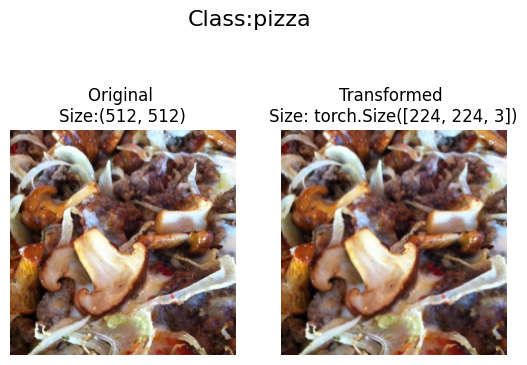

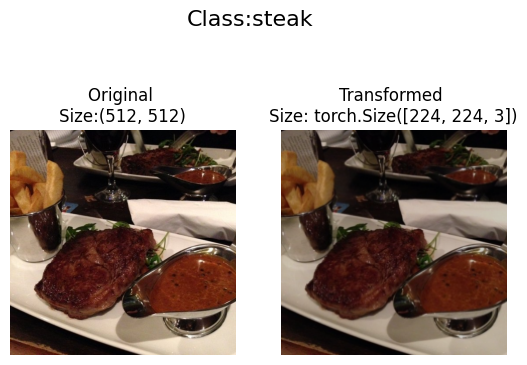

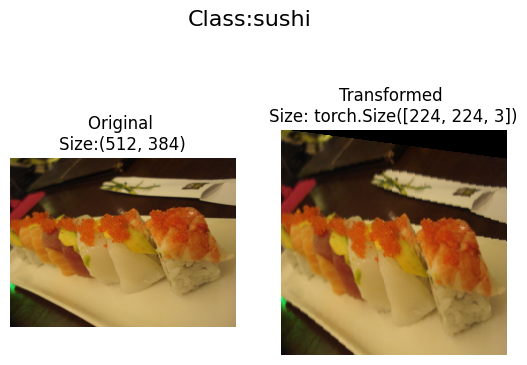

In [145]:
#test the data augmentation created out
#obtain image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
#plotting random images
plot_transformed_images(image_paths=image_path_list, transform=train_transforms,n=3,seed=None)

7. Model0: TinyVGG without data augmentation




Goal: Create a computer vision model to classify if an image is of steak,pizza or sushi

In [146]:
#creating transforms
simple_transform = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])

In [147]:
#1. load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,transform= simple_transform)
#2. turn data into dataloaders
import os
from torch.utils.data import DataLoader

#setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size: {BATCH_SIZE} and {NUM_WORKERS} workers")
#create dataloader'set
train_dataloader_simple = DataLoader(train_data_simple, batch_size = BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(test_data_simple, batch_size=BATCH_SIZE, shuffle=False, num_workers= NUM_WORKERS)
train_dataloader_simple, test_dataloader_simple


Creating DataLoader's with batch size: 32 and 2 workers


(<torch.utils.data.dataloader.DataLoader at 0x17a8508c650>,
 <torch.utils.data.dataloader.DataLoader at 0x17a86f08110>)

In [148]:
#7.2 create TinyVGG model class
class TinyVGG(nn.Module):
    def __init__(self,input_shape:int, hidden_units:int, output_shape:int) ->None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels= input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, #size of the square that's going over the image
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units,kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2)

        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    def forward(self, x:torch.Tensor):
        x=self.conv_block_1(x)
        #printing x.shape
        x= self.conv_block_2(x)
        x=self.classifier(x)
        return x #return self.classifier(self.conv_block_2(self.conv_block_1(x))
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, #number of color channels 3 for RGB
                  hidden_units=10,
                  output_shape=len(train_data.classes))
model_0             

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [149]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single)
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0351]])

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]])

Output prediction label:
tensor([1])

Actual label:
2


In [150]:
#A forward pass on a single image (model test)
#get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))
#2. get a single image from the batch and unsqueeze the image so its shape  fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape} \n")

#3. perfom a forward pass 
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single)
#4 print out progress and convert model logits -> pred probs ->pred label
print(f"Output logits: \n{pred}\n")
print(f"Output prediction probabilities: \n{torch.softmax(pred,dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")




Single image shape: torch.Size([1, 3, 64, 64]) 

Output logits: 
tensor([[0.0637, 0.0615, 0.0382]])

Output prediction probabilities: 
tensor([[0.3364, 0.3357, 0.3279]])

Output prediction label:
tensor([0])

Actual label:
1


In [151]:
from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

#7.5 Create train and test loop functions


functionize training and testing loops

1. train_step() takes in a model a dataloader, a loss function and an optimizer and trains the model on the dataloader

2. test_step() takes in a model , a dataloader and a loss function and evaluates the model on the dataloader

3. train() performs 1 and 2 together for a given number of epochs and returns a results dictionary


In [152]:
#Building a train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    #setting up train loss and train accuracy values
    train_loss, train_acc =0, 0
    #loop through data loader batches
    for batch, (X, y) in enumerate(dataloader):

        #1. forward pass
        y_pred = model(X)
        #2.calc and accumalate loss
        loss =loss_fn(y_pred, y)
        train_loss += loss.item()
        #3. Optimizer.zer_grad()
        optimizer.zero_grad()
        #4. loss backward
        loss.backward()
        #5. optimizer step
        optimizer.step()
        #calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    #adjust metrics to get average loss and accuracy per batch
    train_loss= train_loss/len(dataloader)
    train_acc= train_acc/len(dataloader)
    return train_loss, train_acc




In [ ]:
#<<the more we both stuck together, the more  our outside layers fell off, revealing all our insecurities, fears and dreams.>>>

In [154]:
####<<<<<>>>>>>>>
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X, y
            #X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() /
                         len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [155]:
########<<<<<<>>>>>>
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [156]:
####3###<<<<<<<<<>>>>>>>>>>>
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes))#.to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [01:46<07:05, 106.28s/it]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604


 40%|████      | 2/5 [03:34<05:23, 107.68s/it]

Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979


 60%|██████    | 3/5 [04:30<02:47, 83.66s/it] 

Epoch: 3 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1695 | test_acc: 0.1979


 80%|████████  | 4/5 [06:19<01:33, 93.91s/it]

Epoch: 4 | train_loss: 1.0989 | train_acc: 0.4141 | test_loss: 1.1343 | test_acc: 0.1979


100%|██████████| 5/5 [07:25<00:00, 89.19s/it]

Epoch: 5 | train_loss: 1.0989 | train_acc: 0.2930 | test_loss: 1.1434 | test_acc: 0.1979
Total training time: 445.970 seconds


#Building a test_step function (!!!)
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    #putting the model nto training mode
    model.eval()
    #setting test_loss and test accuracy values
    test_loss, test_data= 0, 0#######
    #turning on inference context manager
    with torch.inference_mode():
        #loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            #

            #1. Forward pass
            test_pred_logits = model(X)

            #2. calculate and accumulate loss
            loss= loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            #calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            # adjusting metrics to get average loss and accuracy per batch
            test_loss = test_loss / len(dataloader)
            test_acc =  test_acc/ len(dataloader)
    return test_loss, test_acc




7.6 Creating a train() function to compile train_step() and test_step()


To put train_step() and test_step() functions together, you package them up in a train() function. The function will train the model as well as evaluate.
Specifically:
    1. take in a model, a DataLoader for training and test sets, an optimizer, a loss function and epochs to perform each train and test step for.

    2. create an empty results dictionary for train_loss, train_accc, test_loss and test_acc values

    3. loop through the training and test step function for a number of epochs

    4.print out what's happening at the end of each epoch.

    5.update the empty results dictionary with the updated metrics each epoch

    5.return the filled.



tqdm progress bar library, keeps track of the number of epochs you've been through.

In [158]:
#<<>>
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
               }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results


In [ ]:
from tqdm.auto import tqdm
#1. take in various parameters required for training and test steps
def train(model:torch.nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
        epochs:int = 5):
    #.create empty results dictionary
    results = {"train_loss":[],
               "train_acc":[],
               "test_loss":[],
               "test_acc": []
               }
    #3. loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer = optimizer)
        test_loss, test_acc=test_step(model=model, dataloader= test_dataloader, loss_fn=loss_fn)
        
        #test_loss, test_acc = test_step(model=model,dataloader=test_dataloader,loss_fn=loss_fn)
        
        #4.print out what's happening
        print(f"Epoch:{epoch+1} |"
        f"train_loss: {train_loss:.4f}|"
        f"train_acc:{train_acc:.4f}|"
        f"test_loss:{test_loss:.4f}|"
        f"test_acc:{test_acc:.4f}"
        )
        #5 update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    #6.Return the filled results at the end of the epochs
    return results
    

7.7 Train and Evaluate Model 0


#has error
#torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS = 5
#recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,#number of color channels(3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes))
#loss function and optimizer setup
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
#starting the timer
from timeit import default_timer as timer
start_timer = timer()
#training model_0
model_0_results = train(model=model_0, train_dataloader = train_dataloader_simple,
test_dataloader =test_dataloader_simple,optimizer=optimizer,loss_fn = loss_fn,epochs=NUM_EPOCHS)
#end timer and printout time taken
end_timer = timer()
print(f"Total training: {end_timer - start_timer:.3f} seconds")


7.8 #Plotting the loss curves of Model 0


loss curves shows the model performance over time


In [159]:
#checking model 0 key results
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [160]:
from typing import Dict, List

In [162]:
#next is to extract each of the keys above and turn them into a plot
def plot_loss_curves(results: Dict[str, List[float]]):
    #getting the loss values of the rsults dict(training &test)
    loss=results["train_loss"]
    test_loss = results['test_loss']

    #accuracy values of the results dict
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    #check how many epochs were there
    epochs = range(len(results['train_loss']))

    #
    plt.figure(figsize=(15,7))
    #plot loss
    plt.subplot(1,2,1)
    plt.plot(epochs,loss,label='train_loss')
    plt.plot(epochs,test_loss, label='test_loss')
    plt.title('loss')
    plt.xlabel('Epochs')
    plt.legend()

    #plot accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs,accuracy, label='train_acccuracy')
    plt.plot(epochs,test_accuracy,label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();



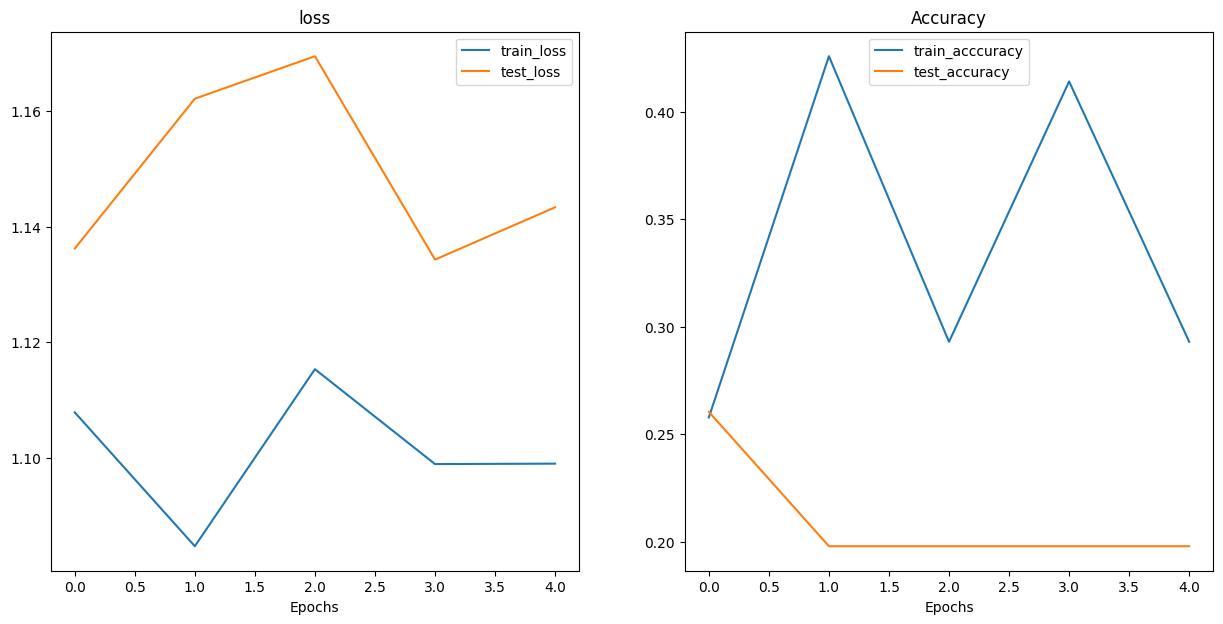

In [163]:
plot_loss_curves(model_0_results)

8.0 #Ideal loss curve



An overfitting model performs better on the training set than the validation/test set. So if training loss is far lower than the test loss then the model is overfitiing. This is to say,the model is learning the patterns in the training too well but those patterns aren't generalizing to the test data.


An undefitting model is when the training and test loss are not as low as you'd like.

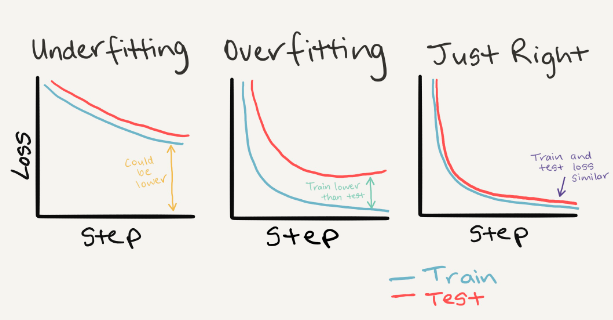

##Dealing with overfitting
common technique = regularization

a. gte more data
b. simplify your model
c.use data augmentation
d. use transfer learning
e. use drop out layers
f. use learning rate decay
g. use early stopping



#Dealing with underfitting
Underfitting = model have poor predictive power on the training and test sets.

a. add more layers (more hidden layers = more predictive power)
b. tweak learning rate/lower learning rate
c. use transfer learning
d. train for longer
e. use less regularization

#9 TinyVGG with Data Augmentation

#9.1 Create transform wih data augmentation


In [164]:
#create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([transforms.Resize((64,64)),
transforms.TrivialAugmentWide(num_magnitude_bins=31),
transforms.ToTensor()])

#Create testing transform (no data augmenation)
test_transform = transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor()])

#9.2 create train and test Datasets and Dataloaders

In [165]:
#turn image folders into Datasets
train_data_augmented= datasets.ImageFolder(train_dir,
transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)
train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [166]:
#turn datasets into Dataloaders
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, batch_size= BATCH_SIZE, shuffle = True, num_workers= NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x17a850a7350>,
 <torch.utils.data.dataloader.DataLoader at 0x17a86374d50>)

#9.3 Construct and train Model 1



In [167]:
#create model 1 
torch.manual_seed(42)
#reusing TinyVGG class 
model_1=TinyVGG(input_shape=3, hidden_units=10,output_shape=len(train_data_augmented.classes))
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [169]:
#!!!!
#set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#set the number of epochs
NUM_EPOCHS = 5
#set the loss function and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(params=model_1.parameters(),lr = 0.001)

#start the timer
from timeit import default_timer as timer
start_time = timer()

#Train model_1
model_1_results=train(model=model_1,train_dataloader=train_dataloader_augmented,
test_dataloader = test_dataloader_simple,
optimizer=optimizer,
loss_fn=loss_fn,
epochs=NUM_EPOCHS)
#END THE TIMER
end_time = timer()
#print time taken
print(f"Total training time: {end_time - start_time:.3f} seconds")


 20%|██        | 1/5 [00:59<03:59, 59.79s/it]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2500 | test_loss: 1.1061 | test_acc: 0.2604


 40%|████      | 2/5 [02:02<03:04, 61.60s/it]

Epoch: 2 | train_loss: 1.0792 | train_acc: 0.4258 | test_loss: 1.1386 | test_acc: 0.2604


 60%|██████    | 3/5 [02:55<01:54, 57.38s/it]

Epoch: 3 | train_loss: 1.0812 | train_acc: 0.4258 | test_loss: 1.1695 | test_acc: 0.2604


 80%|████████  | 4/5 [03:45<00:54, 54.52s/it]

Epoch: 4 | train_loss: 1.1291 | train_acc: 0.3047 | test_loss: 1.1624 | test_acc: 0.2604


100%|██████████| 5/5 [04:44<00:00, 56.96s/it]

Epoch: 5 | train_loss: 1.0901 | train_acc: 0.4258 | test_loss: 1.1477 | test_acc: 0.2604
Total training time: 284.832 seconds


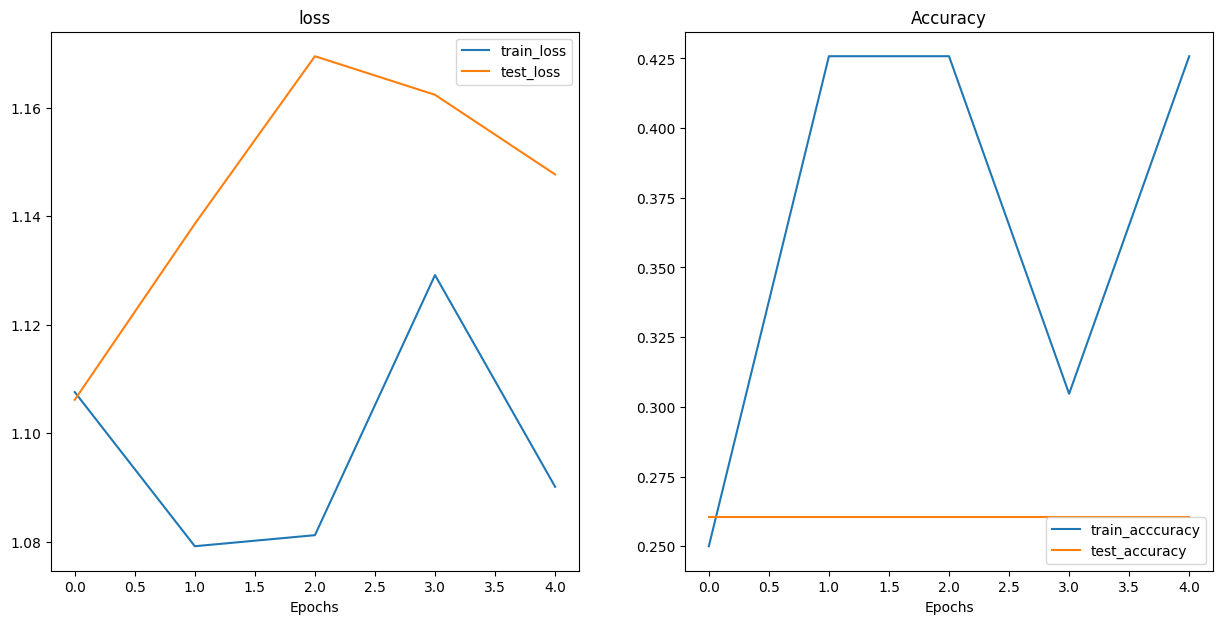

In [170]:
#plot the results
plot_loss_curves(model_1_results)

#10. Compare model results

In [171]:
#turn model results into pandas DataFrame
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.107565,0.250000,1.106138,0.260417
1,1.079154,0.425781,1.138578,0.260417
2,1.081189,0.425781,1.169469,0.260417
3,1.129132,0.304688,1.162360,0.260417
4,1.090120,0.425781,1.147677,0.260417


In [172]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107836,0.257812,1.136208,0.260417
1,1.084645,0.425781,1.162168,0.197917
2,1.115309,0.292969,1.169526,0.197917
3,1.098876,0.414062,1.134295,0.197917
4,1.098950,0.292969,1.143362,0.197917


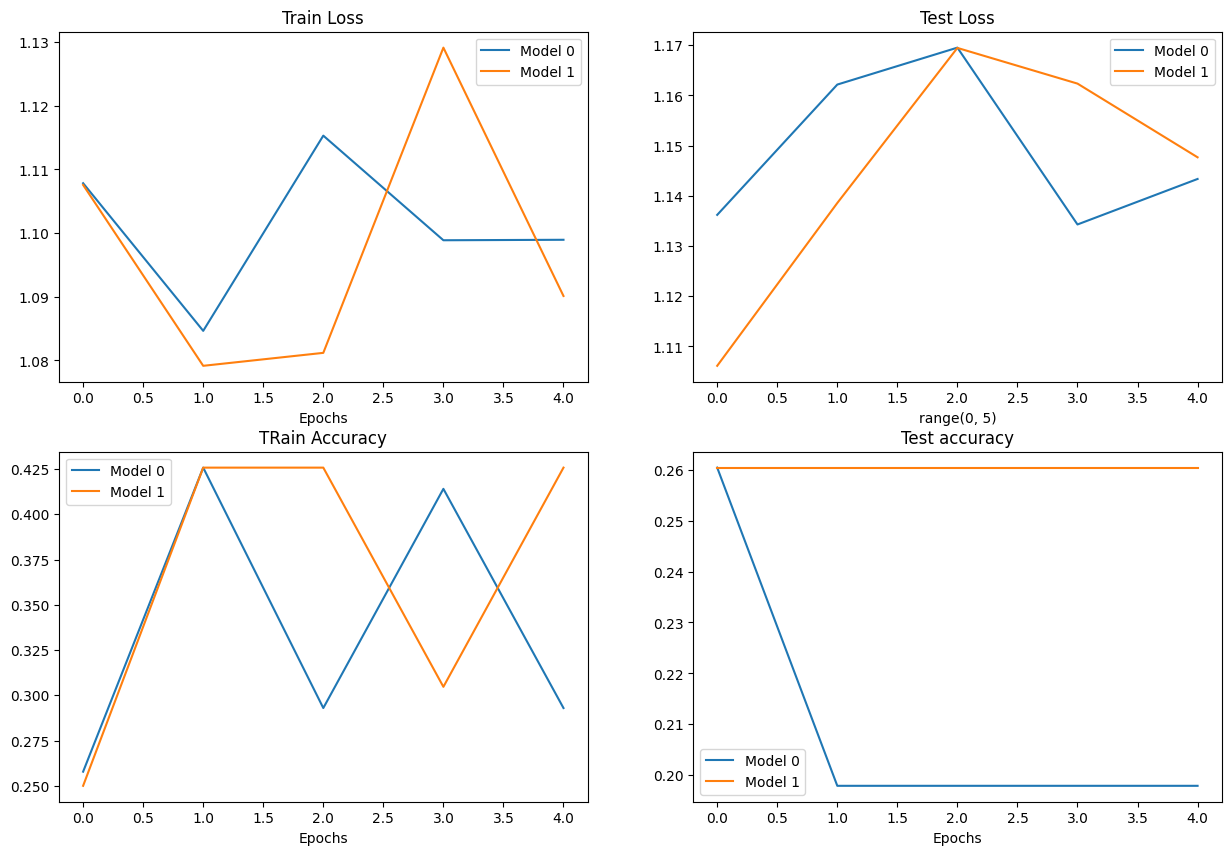

In [173]:
#use matplotlib to visualize ther results ofmodel_0 and model_1
#set up plot
plt.figure(figsize=(15,10))
#get the number of epochs
epochs = range(len(model_0_df))
#plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label = "Model 0")
plt.plot(epochs,model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

#plot the test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel(epochs)
plt.legend()

#plot train accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label ="Model 0")
plt.plot(epochs,model_1_df["train_acc"], label = "Model 1")
plt.title("TRain Accuracy")
plt.xlabel("Epochs")
plt.legend()

#plot test accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs,model_1_df["test_acc"], label="Model 1")
plt.title("Test accuracy")
plt.xlabel("Epochs")
plt.legend()


11. Making a prediction on a custom image




To make a prediction on a custom image, frist preprocess it in a way that matches the type of data the model was trained on. This is to say, convert custom imageto a tensor

# Download custom image
import requests

# Setup custom image path
custom_image_path = "./Pytorch/data/04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get(
            "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")


#downloading custom image
import requests

#setup custom image path
custom_image_path = "./data_path/04-pizza-dad.jpeg"

#download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open (custom_image_path, "wb") as f:
        request =  requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exist, skipping download. ")



In [174]:
#loading in a custom image with pytorch
#PyTorch's torchvision.io.read_image() function reads a jpeg or png image and turn it into a 3-D RGB or grayscale torch.Tensor with values of datatype uint8 in range[0,255]
import torchvision
custom_image_uint8 = torchvision.io.read_image("./data/04-pizza-dad.jpeg/04-pizza-dad.jpeg")

#print out image data
print(f"Custom image tensor: \n {custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor: 
 tensor([[[154, 175, 181,  ...,  21,  18,  14],
         [146, 167, 180,  ...,  21,  18,  15],
         [124, 146, 171,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 189, 193,  ...,  22,  19,  15],
         [163, 181, 194,  ...,  22,  19,  16],
         [141, 163, 185,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 106, 104, 102],
         [ 47,  38,  24,  ..., 108, 105, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[117, 138, 145,  ...,  17,  14,  10],
         [109, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  54,  52,  50],
         [ 27,  18,   4,  ...,  50,  47,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

custom image d

Now, the image is in tensor format, but it isof datatype torch.uint8 and its values are between[0,255] but our model takes image tensors of datatype torch.float32 and with values between [0,1]

So before using the custom image with the model, convert it first to the same format as the data the model is trained on.

In [175]:
#load image and convert the tensor values to float32
custom_image = torchvision.io.read_image("./data/04-pizza-dad.jpeg/04-pizza-dad.jpeg")

#dividethe image pixel values by 255 to get them between [0,1]
custom_image=custom_image/255

#print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape:{custom_image.shape}\n")
print(f"Custom image datatype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6863, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6549, 0.7059,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6706,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7412, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7098, 0.7608,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7255,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4157, 0.4078, 0.4000],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4118, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4588, 0.5412, 0.5686,  ..., 0.0667, 0.0549, 0.0392],
         [0.4275, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

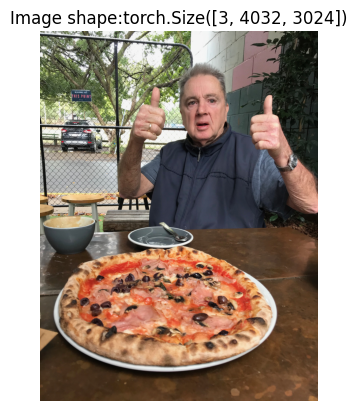

In [176]:
#11.2 Predictoing on custom images with a trained PyTorch model
#Now the data is in the same format as the model except for shape. Our model was trained on images with shape[3,64,64] whereas the custom image is currently [3,4032,3024]
#we need to make sure the shapes match

#plot the custom image
import matplotlib.pyplot as plt
plt.imshow(custom_image.permute(1,2,0)) #permute image dimensions from CHW to HWC
plt.title(f"Image shape:{custom_image.shape}")
plt.axis(False);

In [177]:
from torchvision import transforms
#create transform pipeline to resize image to same size as the model was trained on
custom_image_transform = transforms.Compose([transforms.Resize((64,64)),])
#transform target image
custom_image_transformed = custom_image_transform(custom_image)

#print out original shape and new shape
print(f"Original shape:{custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape:torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


d:\DSAIL\img_detector\img_detector\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [179]:
#make predictions on the image
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

from above, there is a shape error. Since we only converted custom image to be the same size as the images the model was trained on, but we fforgot one dimension--The Batch size

model expects image tensors with batch size dimension at the start (NCHW, where N is the batch size) but custom image is currently only CHW. To add a batch size dimension, use torch.unsqueeze(dim=0) to add an extra dimension.



In [180]:
model_1.eval()
with torch.inference_mode():
    #add extra dimension to the image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    #print out diff shapes
    print(f"Custom image transformed shape:{custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    #make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0))

Custom image transformed shape:torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


#Classical and most common deeplearning and PyTorch issues are:


    1. WRONG DATATYPES- model expecting torch.float32 whereas custom image was uint8

    2. WRONG DEVICE- model/data not on the same device cpu/gpu

    3.WRONG SHAPES- model expecting image input of (N,C,H,W) whereas custom image tensor was of shape (CHW)

In [181]:
#model's predictions
custom_image_pred

tensor([[ 0.1150,  0.0340, -0.1403]])

above predictions are in logit form(i.e the raw outputs of a model)

next we convert them from logits->prediction probabilities->prediction labels

In [182]:
#print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

#convert logits -->> prediction probabilities (using torch.softmax() for multiclass classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

#convert prediction probabilities -->> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim =1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1150,  0.0340, -0.1403]])
Prediction probabilities: tensor([[0.3708, 0.3419, 0.2873]])
Prediction label: tensor([0])


In [184]:
#convert the prediction label from index/tensor form to a string class name
#find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label]
custom_image_pred_class

'pizza'

11.3 Putting customimage prediction together

--Put all the above steps together in a function to simplify things up. The function will:
            1.Takes in a target image path and convert to the right datatype for our model(torch.float32)
            2. ensures the target pixel values are in the range[0,1]
            3. transforms the target image if necessary
            4. ensure the model is on the target device.
            5. make a prediction on the target image with a trained model
            6. convert the model output logits to prediction probabilities
            7. convert the prediction probabilities to prediction labels
            8. plot the target image alongside the model prediction and prediction probability

In [193]:
def pred_and_plot_image(model: torch.nn.Module,
                         image_path:str,
                         class_names:List[str]= None,
                         transform=None):
                         #device: torch.device=device):
        '''Makes a prediction on a target image and plots  the image with its prediction '''
        #1.load in image and convert the tensor values to float32
        target_image=torchvision.io.read_image(str(image_path)).type(torch.float32)

        #2.divide the image pixel values by 255 to get them between [0,1]
        target_image = target_image/255.

        #3.transform if necessary
        if transform:
            target_image= transform(target_image)

        #4. ensuring th emodel is on the device
        #model.to(device)

        #5. Turn on model evaluation mode and inference mode
        model.eval()
        with torch.inference_mode():
            #add extra dimension to the image
            target_image = target_image.unsqueeze(dim=0)

            #make a prediction on image with an extra dimension
            target_image_pred = model(target_image)

        #6. Convert logits -> prediction probabilities (using torch.softmax() for multiclass classification)
        target_image_pred_probs = torch.softmax(target_image_pred, dim =1)

        #7. convert pred probs -->>prediction labels
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim =1)

        #8. plot the image alongside the prediction and prediction probability
        plt.imshow(target_image.squeeze().permute(1,2,0)) #ensure its the right size formatplotlib
        if class_names:
            title = f"pred:{class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
        else:
            title = f"Pred:{target_image_pred_label} | Prob: {target_image_pred_probs.max():.3f}"
        plt.title("title")
        plt.axis(False)



d:\DSAIL\img_detector\img_detector\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


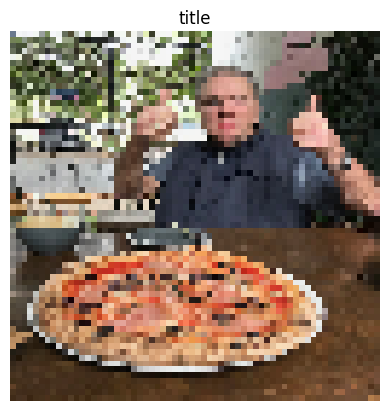

In [194]:
pred_and_plot_image(model=model_1,
                    image_path="./data/04-pizza-dad.jpeg/04-pizza-dad.jpeg",
                    class_names=class_names,
                    transform= custom_image_transform)